In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import scipy as spy
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

data = {}
for i in range(5):
    data[['ukc', 'ukt', 'usc', 'ust', 'it'][i]] = pd.read_csv(f"data/{['UKc', 'UKt', 'USc', 'USt', 'IT'][i]}.txt", sep='\t', parse_dates=[3, 4])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
data['ukc'].head()

,ego,alter,pair,time,date,t,a
0,-0x2670406d6ac46a4e,-0x1221a7b3adb1c6ed,-0x2a416cf8a6fa235d,2007-09-28 22:19:00,2007-09-28,207,0
1,-0x2670406d6ac46a4e,-0x1221a7b3adb1c6ed,-0x2a416cf8a6fa235d,2007-09-29 20:14:00,2007-09-29,208,1
2,-0x2670406d6ac46a4e,-0x1221a7b3adb1c6ed,-0x2a416cf8a6fa235d,2007-09-30 19:43:00,2007-09-30,209,2
3,-0x2670406d6ac46a4e,-0x1221a7b3adb1c6ed,-0x2a416cf8a6fa235d,2007-09-30 19:48:00,2007-09-30,209,2
4,-0x2670406d6ac46a4e,-0x1221a7b3adb1c6ed,-0x2a416cf8a6fa235d,2007-09-30 19:48:00,2007-09-30,209,2


In [13]:
data['ukc'].describe()

,t,a
count,107542.000000,107542.000000
mean,274.586924,174.859934
std,147.960225,151.946838
min,0.000000,0.000000
25%,160.000000,36.000000
50%,274.000000,145.000000
75%,404.000000,280.000000
max,545.000000,534.000000


In [14]:
data['it'].head()

,ego,alter,pair,time,date,t,tau,a
0,-0x1222339268eeddbd,-0x11dfad3c7336ab5d,0x4a0f1b22243afa25,2013-03-27 17:13:07,2013-03-27,54,54,0
1,-0x1222339268eeddbd,-0x13d717c36cb46e90,0x2b9a5bafd88c7828,2013-04-27 20:19:15,2013-04-27,85,85,0
2,-0x1222339268eeddbd,-0x13d717c36cb46e90,0x2b9a5bafd88c7828,2013-05-01 21:28:47,2013-05-01,89,89,4
3,-0x1222339268eeddbd,-0x13d717c36cb46e90,0x2b9a5bafd88c7828,2013-05-03 19:31:19,2013-05-03,91,91,6
4,-0x1222339268eeddbd,-0x1518063fe72efd36,-0x546ee7c17d64a88,2014-04-08 16:04:08,2014-04-08,431,431,0


In [15]:
data['it'].rename(columns={"t": "t_old", "tau": "t"},inplace=True)
data['it'].head()

,ego,alter,pair,time,date,t_old,t,a
0,-0x1222339268eeddbd,-0x11dfad3c7336ab5d,0x4a0f1b22243afa25,2013-03-27 17:13:07,2013-03-27,54,54,0
1,-0x1222339268eeddbd,-0x13d717c36cb46e90,0x2b9a5bafd88c7828,2013-04-27 20:19:15,2013-04-27,85,85,0
2,-0x1222339268eeddbd,-0x13d717c36cb46e90,0x2b9a5bafd88c7828,2013-05-01 21:28:47,2013-05-01,89,89,4
3,-0x1222339268eeddbd,-0x13d717c36cb46e90,0x2b9a5bafd88c7828,2013-05-03 19:31:19,2013-05-03,91,91,6
4,-0x1222339268eeddbd,-0x1518063fe72efd36,-0x546ee7c17d64a88,2014-04-08 16:04:08,2014-04-08,431,431,0


In [16]:
t0 = dt.datetime.now()
weekdays = {}
for c in data.keys():
    df = data[c].copy(deep=True)
    df['weekday'] = df['date'].map(lambda i: i.day_name())
    weekdays[c] = {}
    for t in df['t'].unique():
        df1 = df.loc[df['t'] == t]
        weekdays[c][t] = df1.iloc[0]['weekday']

In [17]:
def get_teeth(calls, tau=False):
    lf = calls.groupby('pair')[['a']].max()
    if tau:
        to = calls.groupby('pair')[['tau']].min().rename({'tau': 't', 'a': 'ell'}, axis='columns')
    else:
        to = calls.groupby('pair')[['t']].min()
    df = to.merge(lf, left_index=True, right_index=True, how='left').rename({'t': 'to', 'a': 'ell'}, axis='columns')
    df = df.sort_values(by=['to', 'ell']).reset_index()
    df['x'] = df['to'] + df.index
    result = pd.DataFrame()
    for t in df['to'].unique():
        tdf = df.loc[df['to'] == t].reset_index(drop=True)
        tdf['ac'] = tdf.index
        result = result.append(tdf)
    result = result.reset_index(drop=True)
    at = result.groupby('to')['pair'].count()
    result['xrel'] = result.index.map(lambda i: (result.at[i, 'ac'] / at[result.at[i, 'to']]) + result.at[i, 'to'])
    return result

In [18]:
teeth = {}
for c in data.keys():
    df = get_teeth(data[c])
    teeth[c] = df

In [19]:
teeth['ukc'].head()

,pair,to,ell,x,ac,xrel
0,-0x1eab7b635b8e67f9,0,0,0,0,0.000000
1,-0x449a28636e7cd1e,0,0,1,1,0.026316
2,-0xa6c180515c6492e,0,0,2,2,0.052632
3,0x1a5840b30f3ef537,0,0,3,3,0.078947
4,0x46252f4cc7c6a4b0,0,0,4,4,0.105263


# UK (DAY0)

In [20]:
teeth['ukc'].describe()

,to,ell,x,ac,xrel
count,6837.000000,6837.000000,6837.000000,6837.000000,6837.000000
mean,226.589586,77.985374,3644.589586,9.354834,227.050680
std,158.608008,141.603496,2131.926594,10.799039,158.598707
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,0.000000,1789.000000,3.000000,80.312500
50%,217.000000,0.000000,3635.000000,6.000000,217.500000
75%,360.000000,93.000000,5487.000000,12.000000,360.538462
max,543.000000,534.000000,7379.000000,80.000000,543.500000


In [16]:
teeth['ukc100']=teeth['ukc'].loc[teeth['ukc']['ell'] <100]
teeth['ukc100'].describe()

,to,ell,x,ac,xrel
count,5169.000000,5169.000000,5169.000000,5169.000000,5169.000000
mean,260.433159,7.862836,4108.872316,6.160960,260.801639
std,155.349730,19.862432,2043.286005,6.110155,155.405464
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,123.000000,0.000000,2385.000000,2.000000,123.555556
50%,258.000000,0.000000,4230.000000,5.000000,258.125000
75%,400.000000,1.000000,5936.000000,9.000000,400.000000
max,543.000000,99.000000,7379.000000,60.000000,543.500000


In [17]:
teeth['ukc200']=teeth['ukc'].loc[teeth['ukc']['ell'] <200]
teeth['ukc200'].describe()

,to,ell,x,ac,xrel
count,5713.000000,5713.000000,5713.000000,5713.000000,5713.000000
mean,254.245580,21.141607,4029.111850,6.806406,254.645831
std,154.354381,45.968489,2039.150953,6.639157,154.402586
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,119.000000,0.000000,2310.000000,2.000000,119.034483
50%,253.000000,0.000000,4170.000000,5.000000,253.444444
75%,387.000000,9.000000,5795.000000,9.000000,387.000000
max,543.000000,199.000000,7379.000000,63.000000,543.500000


In [18]:
teeth['ukc300']=teeth['ukc'].loc[teeth['ukc']['ell'] <300]
teeth['ukc300'].describe()

,to,ell,x,ac,xrel
count,6110.000000,6110.000000,6110.000000,6110.000000,6110.000000
mean,248.175286,35.799182,3949.742881,7.342062,248.598442
std,152.990710,71.579407,2027.462839,7.145921,153.027979
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,116.000000,0.000000,2277.250000,2.000000,116.687500
50%,240.000000,0.000000,4021.500000,6.000000,240.763158
75%,376.000000,27.000000,5684.750000,10.000000,376.150000
max,543.000000,299.000000,7379.000000,65.000000,543.500000


In [36]:
# start from 200 day (<100)
daynames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_uk1_100 = {}
for nw in [7 * weeks for weeks in [8,12,16,20]]:
    subpairs = teeth['ukc100'].loc[(teeth['ukc100']['to'] >= 0) & (teeth['ukc100']['to'] < 0 + nw)]
    subdata = data['ukc'][data['ukc']['pair'].isin(subpairs['pair'])].copy()
    subsubdata = pd.DataFrame()
    for t in subpairs['to'].unique():
        alters = list(subpairs.loc[subpairs['to'] == t]['pair'])
        tmp = subdata[subdata['pair'].isin(alters)]
        tmp = tmp.loc[tmp['t'] <= t + 100]
        subsubdata = subsubdata.append(tmp)
    tt = get_teeth(subsubdata)
    tt['weekday'] = tt['to'].map(lambda x: weekdays['ukc'][x])
    weekly_uk1_100[nw // 7] = pd.DataFrame()
    for i in range(7):
        tmp = tt.loc[tt['weekday'] == daynames[i]]
        tmp = tmp.sort_values(by=['ell']).reset_index(drop=True)
        tmp['xrel'] = tmp.index.map(lambda x: (x / len(tmp)) + i*2)
        weekly_uk1_100[nw // 7] = weekly_uk1_100[nw // 7].append(tmp).reset_index(drop=True)
        weekly_uk1_100[nw // 7]['group'] = np.where(weekly_uk1_100[nw // 7]['weekday']
                                   .isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday','weekend')

In [37]:
# start from 200 day (<200)
daynames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_uk1_200 = {}
for nw in [7 * weeks for weeks in [8,12,16,20]]:
    subpairs = teeth['ukc200'].loc[(teeth['ukc200']['to'] >= 0) & (teeth['ukc200']['to'] < 0 + nw)]
    subdata = data['ukc'][data['ukc']['pair'].isin(subpairs['pair'])].copy()
    subsubdata = pd.DataFrame()
    for t in subpairs['to'].unique():
        alters = list(subpairs.loc[subpairs['to'] == t]['pair'])
        tmp = subdata[subdata['pair'].isin(alters)]
        tmp = tmp.loc[tmp['t'] <= t + 100]
        subsubdata = subsubdata.append(tmp)
    tt = get_teeth(subsubdata)
    tt['weekday'] = tt['to'].map(lambda x: weekdays['ukc'][x])
    weekly_uk1_200[nw // 7] = pd.DataFrame()
    for i in range(7):
        tmp = tt.loc[tt['weekday'] == daynames[i]]
        tmp = tmp.sort_values(by=['ell']).reset_index(drop=True)
        tmp['xrel'] = tmp.index.map(lambda x: (x / len(tmp)) + i*2)
        weekly_uk1_200[nw // 7] = weekly_uk1_200[nw // 7].append(tmp).reset_index(drop=True)
        weekly_uk1_200[nw // 7]['group'] = np.where(weekly_uk1_200[nw // 7]['weekday']
                                   .isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday','weekend')

In [38]:
# start from 200 day (<300)
daynames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_uk1_300 = {}
for nw in [7 * weeks for weeks in [8,12,16,20]]:
    subpairs = teeth['ukc300'].loc[(teeth['ukc300']['to'] >= 0) & (teeth['ukc300']['to'] < 0 + nw)]
    subdata = data['ukc'][data['ukc']['pair'].isin(subpairs['pair'])].copy()
    subsubdata = pd.DataFrame()
    for t in subpairs['to'].unique():
        alters = list(subpairs.loc[subpairs['to'] == t]['pair'])
        tmp = subdata[subdata['pair'].isin(alters)]
        tmp = tmp.loc[tmp['t'] <= t + 100]
        subsubdata = subsubdata.append(tmp)
    tt = get_teeth(subsubdata)
    tt['weekday'] = tt['to'].map(lambda x: weekdays['ukc'][x])
    weekly_uk1_300[nw // 7] = pd.DataFrame()
    for i in range(7):
        tmp = tt.loc[tt['weekday'] == daynames[i]]
        tmp = tmp.sort_values(by=['ell']).reset_index(drop=True)
        tmp['xrel'] = tmp.index.map(lambda x: (x / len(tmp)) + i*2)
        weekly_uk1_300[nw // 7] = weekly_uk1_300[nw // 7].append(tmp).reset_index(drop=True)
        weekly_uk1_300[nw // 7]['group'] = np.where(weekly_uk1_300[nw // 7]['weekday']
                                   .isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday','weekend')

In [22]:
weekly_uk1_300[12].describe()

,to,ell,x,ac,xrel
count,1217.000000,1217.000000,1217.000000,1217.000000,1217.000000
mean,36.686113,18.231717,644.686113,10.372227,6.653246
std,26.007054,31.490217,377.262704,10.548852,3.836807
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,0.000000,316.000000,3.000000,2.927273
50%,37.000000,0.000000,645.000000,7.000000,6.709677
75%,56.000000,26.000000,968.000000,14.000000,10.196172
max,83.000000,100.000000,1299.000000,65.000000,12.992701


In [23]:
weekly_uk1_300[12].head()

,pair,to,ell,x,ac,xrel,weekday,group
0,-0x1eab7b635b8e67f9,0,0,0,0,0.000000,Monday,weekday
1,-0x3583329854376421,49,0,862,1,0.006623,Monday,weekday
2,-0x3479a2ee3b87b69b,49,0,861,0,0.013245,Monday,weekday
3,0x6d404cf1ed6b9f04,42,0,794,11,0.019868,Monday,weekday
4,0x5b4c2f33857a090f,42,0,793,10,0.026490,Monday,weekday


In [39]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]/2,round(y[i], 2))

In [40]:
for nw in [7 * weeks for weeks in list(range(1,13))]:
    weekly_uk1_100[12].loc[(weekly_uk1_100[12]['to'] >= 0 + nw -7) & (weekly_uk1_100[12]['to'] < 0 + nw),'week'] = nw // 7
for nw in [7 * weeks for weeks in list(range(1,13))]:
    weekly_uk1_200[12].loc[(weekly_uk1_200[12]['to'] >= 0 + nw -7) & (weekly_uk1_200[12]['to'] < 0 + nw),'week'] = nw // 7
for nw in [7 * weeks for weeks in list(range(1,13))]:
    weekly_uk1_300[12].loc[(weekly_uk1_300[12]['to'] >= 0 + nw -7) & (weekly_uk1_300[12]['to'] < 0 + nw),'week'] = nw // 7

In [41]:
# boxplot
#new alter
count100 = weekly_uk1_100[12].groupby(['week','group']).size().to_frame(name = 'count').reset_index()
count100['count'] = np.where(count100['group'] == 'weekday',  count100['count']/5, count100['count']/2)

count200 = weekly_uk1_200[12].groupby(['week','group']).size().to_frame(name = 'count').reset_index()
count200['count'] = np.where(count200['group'] == 'weekday',  count200['count']/5, count200['count']/2)

count300 = weekly_uk1_300[12].groupby(['week','group']).size().to_frame(name = 'count').reset_index()
count300['count'] = np.where(count300['group'] == 'weekday',  count300['count']/5, count300['count']/2)
count100.head()

,week,group,count
0,1.0,weekday,17.0
1,1.0,weekend,16.5
2,2.0,weekday,15.6
3,2.0,weekend,17.0
4,3.0,weekday,8.0


In [27]:
count100 = count100.rename(columns={"count": "alter_count_100"})
count200 = count200.rename(columns={"count": "alter_count_200"})
count300 = count300.rename(columns={"count": "alter_count_300"})
count100.head()

,week,group,alter_count_100
0,1.0,weekday,17.0
1,1.0,weekend,16.5
2,2.0,weekday,15.6
3,2.0,weekend,17.0
4,3.0,weekday,8.0


In [28]:
alter_count = pd.merge(pd.merge(count100,count200,left_index=True, right_index=True),count300,left_index=True, right_index=True)
alter_count=alter_count.drop(['week_x', 'group_x','week_y','group_y'], axis=1)
alter_count.head()

,alter_count_100,alter_count_200,week,group,alter_count_300
0,17.0,21.0,1.0,weekday,26.4
1,16.5,24.5,1.0,weekend,30.0
2,15.6,19.8,2.0,weekday,21.6
3,17.0,18.5,2.0,weekend,20.0
4,8.0,9.4,3.0,weekday,11.0


In [42]:
# boxplot
#lifetime
lifetime100 = weekly_uk1_100[12].groupby(['week','group']).mean()['ell'].to_frame(name = 'mean').reset_index()
lifetime200 = weekly_uk1_200[12].groupby(['week','group']).mean()['ell'].to_frame(name = 'mean').reset_index()
lifetime300 = weekly_uk1_300[12].groupby(['week','group']).mean()['ell'].to_frame(name = 'mean').reset_index()

In [30]:
lifetime100.head()

,week,group,mean
0,1.0,weekday,16.941176
1,1.0,weekend,17.515152
2,2.0,weekday,11.910256
3,2.0,weekend,11.617647
4,3.0,weekday,13.050000


In [31]:
lifetime100 = lifetime100.rename(columns={"mean": "lifetime_mean_100"})
lifetime200 = lifetime200.rename(columns={"mean": "lifetime_mean_200"})
lifetime300 = lifetime300.rename(columns={"mean": "lifetime_mean_300"})
lifetime100.head()

,week,group,lifetime_mean_100
0,1.0,weekday,16.941176
1,1.0,weekend,17.515152
2,2.0,weekday,11.910256
3,2.0,weekend,11.617647
4,3.0,weekday,13.050000


In [32]:
lifetime_mean = pd.merge(pd.merge(lifetime100,lifetime200,left_index=True, right_index=True),lifetime300,left_index=True, right_index=True)
lifetime_mean=lifetime_mean.drop(['week_x', 'group_x','week_y','group_y'], axis=1)
lifetime_mean.head()

,lifetime_mean_100,lifetime_mean_200,week,group,lifetime_mean_300
0,16.941176,23.714286,1.0,weekday,31.598485
1,17.515152,28.448980,1.0,weekend,37.283333
2,11.910256,16.575758,2.0,weekday,18.981481
3,11.617647,13.864865,2.0,weekend,18.100000
4,13.050000,18.106383,3.0,weekday,24.400000


In [33]:
boxplot_data = pd.merge(alter_count,lifetime_mean,left_index=True, right_index=True)
boxplot_data=boxplot_data.drop(['week_x', 'group_x'], axis=1)
boxplot_data = boxplot_data.rename(columns={"week_y": "week","group_y": "group"})
boxplot_data = boxplot_data[['week','group','alter_count_100','alter_count_200','alter_count_300','lifetime_mean_100','lifetime_mean_200','lifetime_mean_300']]
boxplot_data.head()

,week,group,alter_count_100,alter_count_200,alter_count_300,lifetime_mean_100,lifetime_mean_200,lifetime_mean_300
0,1.0,weekday,17.0,21.0,26.4,16.941176,23.714286,31.598485
1,1.0,weekend,16.5,24.5,30.0,17.515152,28.448980,37.283333
2,2.0,weekday,15.6,19.8,21.6,11.910256,16.575758,18.981481
3,2.0,weekend,17.0,18.5,20.0,11.617647,13.864865,18.100000
4,3.0,weekday,8.0,9.4,11.0,13.050000,18.106383,24.400000


In [34]:
boxplot_data.to_excel(r'E:\UK_day0_boxplot_data.xlsx', index = False)

[Text(0, 0.5, 'average duration of relationship')]

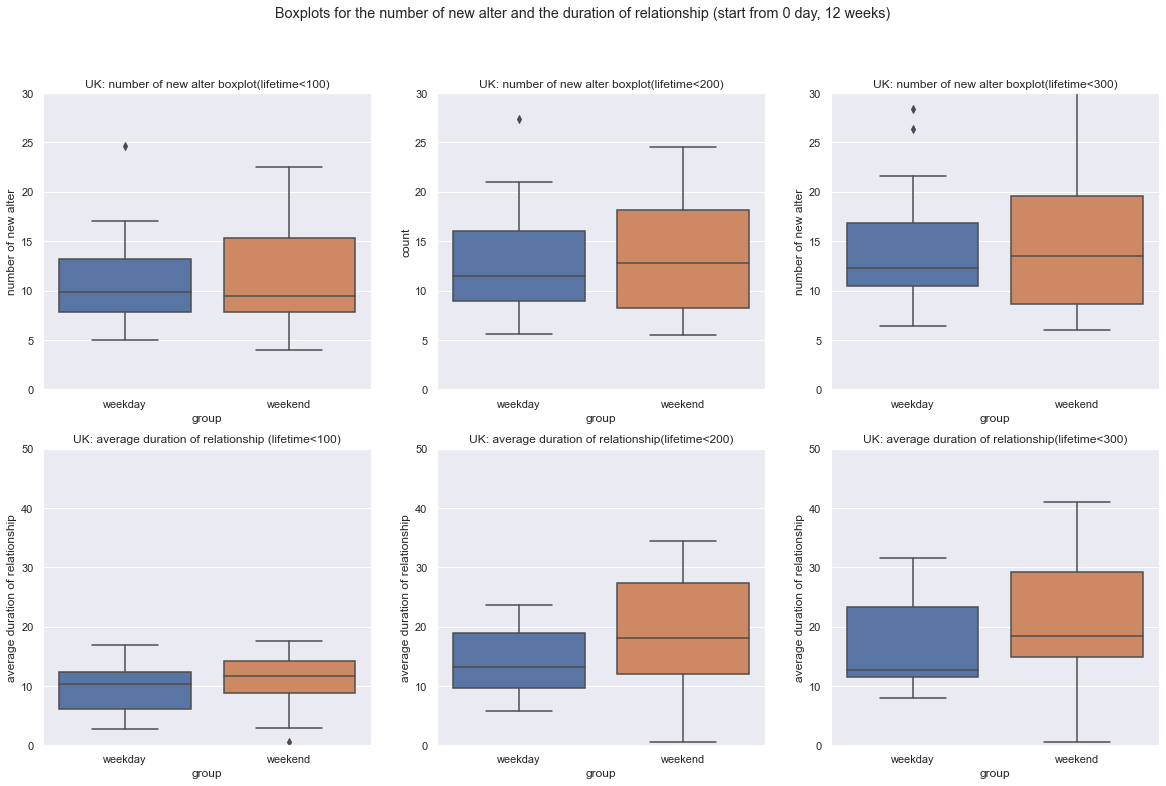

In [44]:
sns.set(rc={'figure.figsize':(20,12)})

fig, axes = plt.subplots(2, 3)
plt.suptitle('Boxplots for the number of new alter and the duration of relationship (start from 0 day, 12 weeks)')
sns.boxplot(x='group', y='count', data=count100, ax=axes[0,0]).set_title("UK: number of new alter boxplot(lifetime<100)")
sns.boxplot(x='group', y='count', data=count200, ax=axes[0,1]).set_title("UK: number of new alter boxplot(lifetime<200)")
sns.boxplot(x='group', y='count', data=count300, ax=axes[0,2]).set_title("UK: number of new alter boxplot(lifetime<300)")

sns.boxplot(x='group', y='mean', data=lifetime100, ax=axes[1,0]).set_title("UK: average duration of relationship (lifetime<100)")
sns.boxplot(x='group', y='mean', data=lifetime200, ax=axes[1,1]).set_title("UK: average duration of relationship(lifetime<200)")
sns.boxplot(x='group', y='mean', data=lifetime300, ax=axes[1,2]).set_title("UK: average duration of relationship(lifetime<300)")

axes[0,0].set(ylim=(0, 30))
axes[0,0].set(ylabel='number of new alter')
axes[0,1].set(ylim=(0, 30))
axes[0,2].set(ylabel='number of new alter')
axes[0,2].set(ylim=(0, 30))
axes[0,2].set(ylabel='number of new alter')
axes[1,0].set(ylim=(0, 50))
axes[1,0].set(ylabel='average duration of relationship')
axes[1,1].set(ylim=(0, 50))
axes[1,1].set(ylabel='average duration of relationship')
axes[1,2].set(ylim=(0, 50))
axes[1,2].set(ylabel='average duration of relationship')

# IT (DAY0)

In [21]:
teeth['it'].describe()

,to,ell,x,ac,xrel
count,23674.000000,23674.000000,23674.000000,23674.000000,23674.000000
mean,221.444961,99.894821,12057.944961,26.590901,221.930198
std,181.920612,172.110445,7009.936797,27.941892,181.910489
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,65.000000,0.000000,5983.250000,8.000000,65.510000
50%,178.000000,0.000000,12014.500000,19.000000,178.614583
75%,340.000000,142.000000,18094.750000,36.000000,340.710938
max,698.000000,698.000000,24371.000000,278.000000,698.909091


In [36]:
teeth['it100']=teeth['it'].loc[teeth['it']['ell'] <100]
teeth['it100'].describe()

,to,ell,x,ac,xrel
count,16978.000000,16978.000000,16978.000000,16978.000000,16978.000000
mean,266.623748,6.695606,13942.875015,14.624632,266.995592
std,183.425152,18.590057,6580.107159,11.091189,183.491077
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,111.000000,0.000000,8685.250000,6.000000,111.503906
50%,241.000000,0.000000,14554.500000,12.000000,241.662162
75%,390.000000,0.000000,19560.750000,22.000000,390.472222
max,698.000000,99.000000,24371.000000,75.000000,698.909091


In [37]:
teeth['it200']=teeth['it'].loc[teeth['it']['ell'] <200]
teeth['it200'].describe()

,to,ell,x,ac,xrel
count,18616.000000,18616.000000,18616.000000,18616.000000,18616.000000
mean,258.564192,19.045122,13643.856897,16.475129,258.964890
std,182.168790,44.369745,6621.835529,12.689101,182.226232
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,105.000000,0.000000,8360.750000,6.000000,105.340517
50%,232.000000,0.000000,14136.500000,14.000000,232.178571
75%,380.000000,3.000000,19312.250000,24.000000,380.812500
max,698.000000,199.000000,24371.000000,84.000000,698.909091


In [38]:
teeth['it300']=teeth['it'].loc[teeth['it']['ell'] <300]
teeth['it300'].describe()

,to,ell,x,ac,xrel
count,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000
mean,248.680827,35.783416,13251.086853,18.498108,249.104674
std,181.667095,73.829845,6699.598939,14.707433,181.710645
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,96.000000,0.000000,7780.750000,7.000000,96.062500
50%,218.000000,0.000000,13592.500000,15.000000,218.347222
75%,369.000000,19.000000,19013.250000,27.000000,369.784091
max,698.000000,299.000000,24371.000000,105.000000,698.909091


In [39]:
# start from 0 day (<100)
daynames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_it1_100 = {}
for nw in [7 * weeks for weeks in [8,12,16,20]]:
    subpairs = teeth['it100'].loc[(teeth['it100']['to'] >= 200) & (teeth['it100']['to'] < 200+nw)]
    subdata = data['it'][data['it']['pair'].isin(subpairs['pair'])].copy()
    subsubdata = pd.DataFrame()
    for t in subpairs['to'].unique():
        alters = list(subpairs.loc[subpairs['to'] == t]['pair'])
        tmp = subdata[subdata['pair'].isin(alters)]
        tmp = tmp.loc[tmp['t'] <= t + 100]
        subsubdata = subsubdata.append(tmp)
    tt = get_teeth(subsubdata)
    tt['weekday'] = tt['to'].map(lambda x: weekdays['ukc'][x])
    weekly_it1_100[nw // 7] = pd.DataFrame()
    for i in range(7):
        tmp = tt.loc[tt['weekday'] == daynames[i]]
        tmp = tmp.sort_values(by=['ell']).reset_index(drop=True)
        tmp['xrel'] = tmp.index.map(lambda x: (x / len(tmp)) + i*2)
        weekly_it1_100[nw // 7] = weekly_it1_100[nw // 7].append(tmp).reset_index(drop=True)
        weekly_it1_100[nw // 7]['group'] = np.where(weekly_it1_100[nw // 7]['weekday']
                                   .isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday','weekend')

In [40]:
# start from 0 day (<200)
daynames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_it1_200 = {}
for nw in [7 * weeks for weeks in [8,12,16,20]]:
    subpairs = teeth['it200'].loc[(teeth['it200']['to'] >= 200) & (teeth['it200']['to'] < 200+nw)]
    subdata = data['it'][data['it']['pair'].isin(subpairs['pair'])].copy()
    subsubdata = pd.DataFrame()
    for t in subpairs['to'].unique():
        alters = list(subpairs.loc[subpairs['to'] == t]['pair'])
        tmp = subdata[subdata['pair'].isin(alters)]
        tmp = tmp.loc[tmp['t'] <= t + 100]
        subsubdata = subsubdata.append(tmp)
    tt = get_teeth(subsubdata)
    tt['weekday'] = tt['to'].map(lambda x: weekdays['ukc'][x])
    weekly_it1_200[nw // 7] = pd.DataFrame()
    for i in range(7):
        tmp = tt.loc[tt['weekday'] == daynames[i]]
        tmp = tmp.sort_values(by=['ell']).reset_index(drop=True)
        tmp['xrel'] = tmp.index.map(lambda x: (x / len(tmp)) + i*2)
        weekly_it1_200[nw // 7] = weekly_it1_200[nw // 7].append(tmp).reset_index(drop=True)
        weekly_it1_200[nw // 7]['group'] = np.where(weekly_it1_200[nw // 7]['weekday']
                                   .isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday','weekend')

In [41]:
# start from 0 day (<300)
daynames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_it1_300 = {}
for nw in [7 * weeks for weeks in [8,12,16,20]]:
    subpairs = teeth['it300'].loc[(teeth['it300']['to'] >= 200) & (teeth['it300']['to'] < 200+nw)]
    subdata = data['it'][data['it']['pair'].isin(subpairs['pair'])].copy()
    subsubdata = pd.DataFrame()
    for t in subpairs['to'].unique():
        alters = list(subpairs.loc[subpairs['to'] == t]['pair'])
        tmp = subdata[subdata['pair'].isin(alters)]
        tmp = tmp.loc[tmp['t'] <= t + 100]
        subsubdata = subsubdata.append(tmp)
    tt = get_teeth(subsubdata)
    tt['weekday'] = tt['to'].map(lambda x: weekdays['ukc'][x])
    weekly_it1_300[nw // 7] = pd.DataFrame()
    for i in range(7):
        tmp = tt.loc[tt['weekday'] == daynames[i]]
        tmp = tmp.sort_values(by=['ell']).reset_index(drop=True)
        tmp['xrel'] = tmp.index.map(lambda x: (x / len(tmp)) + i*2)
        weekly_it1_300[nw // 7] = weekly_it1_300[nw // 7].append(tmp).reset_index(drop=True)
        weekly_it1_300[nw // 7]['group'] = np.where(weekly_it1_300[nw // 7]['weekday']
                                   .isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday','weekend')

In [42]:
weekly_it1_300[12].describe()

,to,ell,x,ac,xrel
count,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000
mean,240.646579,10.163063,1650.646579,17.289614,6.501595
std,23.428272,23.913904,837.892328,11.416431,4.088519
min,200.000000,0.000000,200.000000,0.000000,0.000000
25%,221.000000,0.000000,926.000000,8.000000,2.655914
50%,239.000000,0.000000,1649.000000,16.000000,6.587379
75%,260.000000,1.000000,2375.000000,25.000000,10.258398
max,283.000000,100.000000,3103.000000,54.000000,12.997613


In [43]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]/2,round(y[i], 2))

In [44]:
for nw in [7 * weeks for weeks in list(range(1,13))]:
    weekly_it1_100[12].loc[(weekly_it1_100[12]['to'] >= 200 + nw -7) & (weekly_it1_100[12]['to'] < 200 + nw),'week'] = nw // 7
for nw in [7 * weeks for weeks in list(range(1,13))]:
    weekly_it1_200[12].loc[(weekly_it1_200[12]['to'] >= 200 + nw -7) & (weekly_it1_200[12]['to'] < 200 + nw),'week'] = nw // 7
for nw in [7 * weeks for weeks in list(range(1,13))]:
    weekly_it1_300[12].loc[(weekly_it1_300[12]['to'] >= 200 + nw -7) & (weekly_it1_300[12]['to'] < 200 + nw),'week'] = nw // 7

In [45]:
weekly_it1_300[12].head()

,pair,to,ell,x,ac,xrel,weekday,group,week
0,-0x153ad9bd5bec5728,203,0,303,0,0.000000,Monday,weekday,1.0
1,-0x1926aa3cbb763d81,252,0,2120,1,0.002169,Monday,weekday,8.0
2,-0x1027389bf9668b1f,252,0,2119,0,0.004338,Monday,weekday,8.0
3,0x2051cb665027000c,280,0,2985,20,0.006508,Monday,weekday,12.0
4,0x22852eb3913dfcfe,280,0,2986,21,0.008677,Monday,weekday,12.0


In [46]:
#04262022
count300 = weekly_it1_300[12].groupby(['week','weekday']).size().to_frame(name = 'count').reset_index()
count300.to_excel(r'E:\84r it200 count.xlsx', index = False)
count300.head()

,week,weekday,count
0,1.0,Friday,33
1,1.0,Monday,25
2,1.0,Saturday,36
3,1.0,Sunday,31
4,1.0,Thursday,44


In [47]:
lifetime300 = weekly_it1_300[12].groupby(['week','weekday']).mean()['ell'].to_frame(name = 'mean').reset_index()
lifetime300.to_excel(r'E:\84r it200 lifetime.xlsx', index = False)
lifetime300.head()

,week,weekday,mean
0,1.0,Friday,6.939394
1,1.0,Monday,13.720000
2,1.0,Saturday,13.138889
3,1.0,Sunday,11.903226
4,1.0,Thursday,5.068182


In [58]:
# boxplot
#new alter
count100 = weekly_it1_100[12].groupby(['week','group']).size().to_frame(name = 'count').reset_index()
count100['count'] = np.where(count100['group'] == 'weekday',  count100['count']/5, count100['count']/2)

count200 = weekly_it1_200[12].groupby(['week','group']).size().to_frame(name = 'count').reset_index()
count200['count'] = np.where(count200['group'] == 'weekday',  count200['count']/5, count200['count']/2)

count300 = weekly_it1_300[12].groupby(['week','group']).size().to_frame(name = 'count').reset_index()
count300['count'] = np.where(count300['group'] == 'weekday',  count300['count']/5, count300['count']/2)
count100.head()

,week,group,count
0,1.0,weekday,51.2
1,1.0,weekend,34.5
2,2.0,weekday,33.0
3,2.0,weekend,40.5
4,3.0,weekday,38.6


In [63]:
count100 = count100.rename(columns={"count": "alter_count_100"})
count200 = count200.rename(columns={"count": "alter_count_200"})
count300 = count300.rename(columns={"count": "alter_count_300"})
count100.head()

,week,group,alter_count_100
0,1.0,weekday,51.2
1,1.0,weekend,34.5
2,2.0,weekday,33.0
3,2.0,weekend,40.5
4,3.0,weekday,38.6


In [64]:
alter_count = pd.merge(pd.merge(count100,count200,left_index=True, right_index=True),count300,left_index=True, right_index=True)
alter_count=alter_count.drop(['week_x', 'group_x','week_y','group_y'], axis=1)
alter_count.head()

,alter_count_100,alter_count_200,week,group,alter_count_300
0,51.2,65.2,1.0,weekday,80.0
1,34.5,39.5,1.0,weekend,54.5
2,33.0,41.2,2.0,weekday,50.0
3,40.5,45.5,2.0,weekend,53.5
4,38.6,47.0,3.0,weekday,55.6


In [ ]:
#04262022 end

In [59]:
# boxplot
#lifetime
lifetime100 = weekly_it1_100[12].groupby(['week','group']).mean()['ell'].to_frame(name = 'mean').reset_index()
lifetime200 = weekly_it1_200[12].groupby(['week','group']).mean()['ell'].to_frame(name = 'mean').reset_index()
lifetime300 = weekly_it1_300[12].groupby(['week','group']).mean()['ell'].to_frame(name = 'mean').reset_index()

In [65]:
lifetime100 = lifetime100.rename(columns={"mean": "lifetime_mean_100"})
lifetime200 = lifetime200.rename(columns={"mean": "lifetime_mean_200"})
lifetime300 = lifetime300.rename(columns={"mean": "lifetime_mean_300"})
lifetime100.head()

,week,group,lifetime_mean_100
0,1.0,weekday,13.296875
1,1.0,weekend,10.159420
2,2.0,weekday,10.266667
3,2.0,weekend,7.382716
4,3.0,weekday,12.383420


In [66]:
lifetime_mean = pd.merge(pd.merge(lifetime100,lifetime200,left_index=True, right_index=True),lifetime300,left_index=True, right_index=True)
lifetime_mean=lifetime_mean.drop(['week_x', 'group_x','week_y','group_y'], axis=1)
lifetime_mean.head()

,lifetime_mean_100,lifetime_mean_200,week,group,lifetime_mean_300
0,13.296875,21.638037,1.0,weekday,28.525000
1,10.159420,12.835443,1.0,weekend,27.027523
2,10.266667,18.932039,2.0,weekday,24.564000
3,7.382716,11.494505,2.0,weekend,15.280374
4,12.383420,15.889362,3.0,weekday,19.176259


In [67]:
boxplot_data = pd.merge(alter_count,lifetime_mean,left_index=True, right_index=True)
boxplot_data=boxplot_data.drop(['week_x', 'group_x'], axis=1)
boxplot_data = boxplot_data.rename(columns={"week_y": "week","group_y": "group"})
boxplot_data = boxplot_data[['week','group','alter_count_100','alter_count_200','alter_count_300','lifetime_mean_100','lifetime_mean_200','lifetime_mean_300']]
boxplot_data.head()

,week,group,alter_count_100,alter_count_200,alter_count_300,lifetime_mean_100,lifetime_mean_200,lifetime_mean_300
0,1.0,weekday,51.2,65.2,80.0,13.296875,21.638037,28.525000
1,1.0,weekend,34.5,39.5,54.5,10.159420,12.835443,27.027523
2,2.0,weekday,33.0,41.2,50.0,10.266667,18.932039,24.564000
3,2.0,weekend,40.5,45.5,53.5,7.382716,11.494505,15.280374
4,3.0,weekday,38.6,47.0,55.6,12.383420,15.889362,19.176259


In [68]:
boxplot_data.to_excel(r'E:\IT_day0_boxplot_data.xlsx', index = False)

[Text(0, 0.5, 'average duration of relationship')]

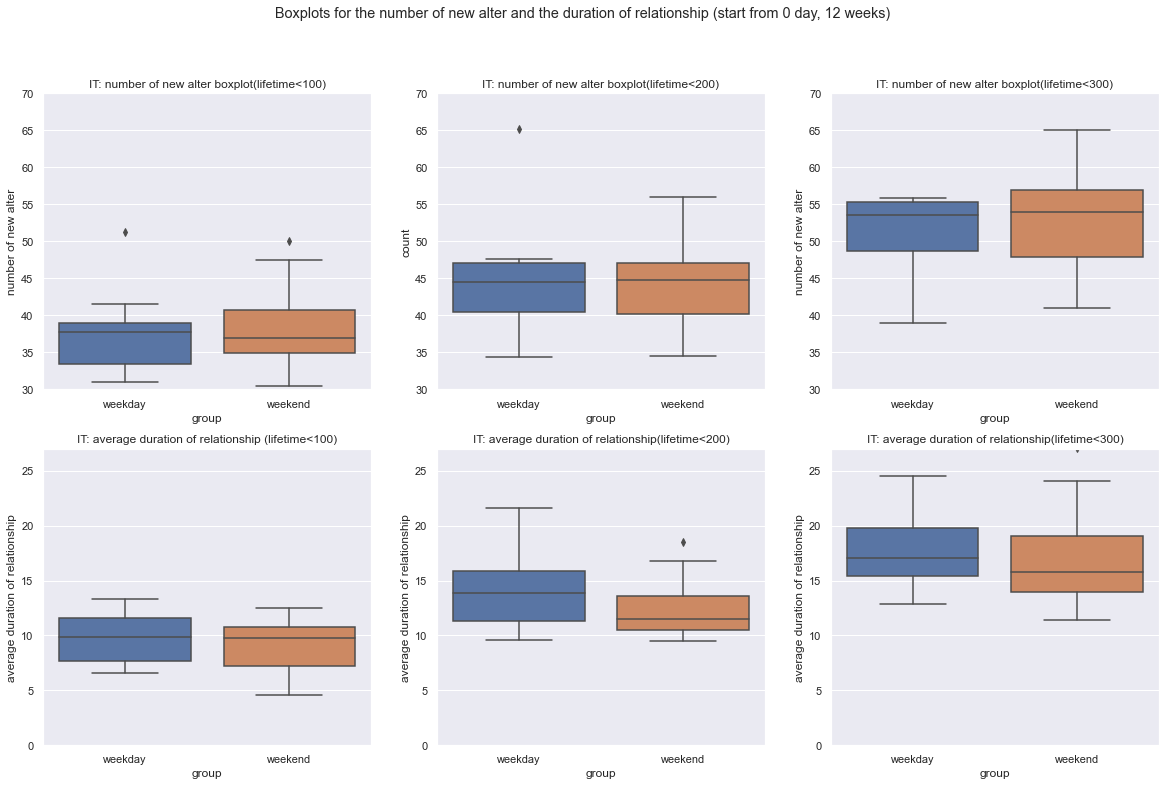

In [62]:
sns.set(rc={'figure.figsize':(20,12)})

fig, axes = plt.subplots(2, 3)
plt.suptitle('Boxplots for the number of new alter and the duration of relationship (start from 0 day, 12 weeks)')
sns.boxplot(x='group', y='count', data=count100, ax=axes[0,0]).set_title("IT: number of new alter boxplot(lifetime<100)")
sns.boxplot(x='group', y='count', data=count200, ax=axes[0,1]).set_title("IT: number of new alter boxplot(lifetime<200)")
sns.boxplot(x='group', y='count', data=count300, ax=axes[0,2]).set_title("IT: number of new alter boxplot(lifetime<300)")

sns.boxplot(x='group', y='mean', data=lifetime100, ax=axes[1,0]).set_title("IT: average duration of relationship (lifetime<100)")
sns.boxplot(x='group', y='mean', data=lifetime200, ax=axes[1,1]).set_title("IT: average duration of relationship(lifetime<200)")
sns.boxplot(x='group', y='mean', data=lifetime300, ax=axes[1,2]).set_title("IT: average duration of relationship(lifetime<300)")

axes[0,0].set(ylim=(30, 70))
axes[0,0].set(ylabel='number of new alter')
axes[0,1].set(ylim=(30, 70))
axes[0,2].set(ylabel='number of new alter')
axes[0,2].set(ylim=(30, 70))
axes[0,2].set(ylabel='number of new alter')
axes[1,0].set(ylim=(0, 27))
axes[1,0].set(ylabel='average duration of relationship')
axes[1,1].set(ylim=(0, 27))
axes[1,1].set(ylabel='average duration of relationship')
axes[1,2].set(ylim=(0, 27))
axes[1,2].set(ylabel='average duration of relationship')


# IT(DAY200)

In [69]:
teeth['it'].describe()

,to,ell,x,ac,xrel
count,23674.000000,23674.000000,23674.000000,23674.000000,23674.000000
mean,221.444961,99.894821,12057.944961,26.590901,221.930198
std,181.920612,172.110445,7009.936797,27.941892,181.910489
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,65.000000,0.000000,5983.250000,8.000000,65.510000
50%,178.000000,0.000000,12014.500000,19.000000,178.614583
75%,340.000000,142.000000,18094.750000,36.000000,340.710938
max,698.000000,698.000000,24371.000000,278.000000,698.909091


In [70]:
# start from 200 day (<100)
daynames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_it1_100 = {}
for nw in [7 * weeks for weeks in [8,12,16,20]]:
    subpairs = teeth['it100'].loc[(teeth['it100']['to'] >= 200) & (teeth['it100']['to'] < 200 + nw)]
    subdata = data['it'][data['it']['pair'].isin(subpairs['pair'])].copy()
    subsubdata = pd.DataFrame()
    for t in subpairs['to'].unique():
        alters = list(subpairs.loc[subpairs['to'] == t]['pair'])
        tmp = subdata[subdata['pair'].isin(alters)]
        tmp = tmp.loc[tmp['t'] <= t + 100]
        subsubdata = subsubdata.append(tmp)
    tt = get_teeth(subsubdata)
    tt['weekday'] = tt['to'].map(lambda x: weekdays['ukc'][x])
    weekly_it1_100[nw // 7] = pd.DataFrame()
    for i in range(7):
        tmp = tt.loc[tt['weekday'] == daynames[i]]
        tmp = tmp.sort_values(by=['ell']).reset_index(drop=True)
        tmp['xrel'] = tmp.index.map(lambda x: (x / len(tmp)) + i*2)
        weekly_it1_100[nw // 7] = weekly_it1_100[nw // 7].append(tmp).reset_index(drop=True)
        weekly_it1_100[nw // 7]['group'] = np.where(weekly_it1_100[nw // 7]['weekday']
                                   .isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday','weekend')

In [71]:
# start from 200 day (<200)
daynames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_it1_200 = {}
for nw in [7 * weeks for weeks in [8,12,16,20]]:
    subpairs = teeth['it200'].loc[(teeth['it200']['to'] >= 200) & (teeth['it200']['to'] < 200 + nw)]
    subdata = data['it'][data['it']['pair'].isin(subpairs['pair'])].copy()
    subsubdata = pd.DataFrame()
    for t in subpairs['to'].unique():
        alters = list(subpairs.loc[subpairs['to'] == t]['pair'])
        tmp = subdata[subdata['pair'].isin(alters)]
        tmp = tmp.loc[tmp['t'] <= t + 100]
        subsubdata = subsubdata.append(tmp)
    tt = get_teeth(subsubdata)
    tt['weekday'] = tt['to'].map(lambda x: weekdays['ukc'][x])
    weekly_it1_200[nw // 7] = pd.DataFrame()
    for i in range(7):
        tmp = tt.loc[tt['weekday'] == daynames[i]]
        tmp = tmp.sort_values(by=['ell']).reset_index(drop=True)
        tmp['xrel'] = tmp.index.map(lambda x: (x / len(tmp)) + i*2)
        weekly_it1_200[nw // 7] = weekly_it1_200[nw // 7].append(tmp).reset_index(drop=True)
        weekly_it1_200[nw // 7]['group'] = np.where(weekly_it1_200[nw // 7]['weekday']
                                   .isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday','weekend')

In [72]:
# start from 200 day (<300)
daynames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_it1_300 = {}
for nw in [7 * weeks for weeks in [8,12,16,20]]:
    subpairs = teeth['it300'].loc[(teeth['it300']['to'] >= 200) & (teeth['it300']['to'] < 200 + nw)]
    subdata = data['it'][data['it']['pair'].isin(subpairs['pair'])].copy()
    subsubdata = pd.DataFrame()
    for t in subpairs['to'].unique():
        alters = list(subpairs.loc[subpairs['to'] == t]['pair'])
        tmp = subdata[subdata['pair'].isin(alters)]
        tmp = tmp.loc[tmp['t'] <= t + 100]
        subsubdata = subsubdata.append(tmp)
    tt = get_teeth(subsubdata)
    tt['weekday'] = tt['to'].map(lambda x: weekdays['ukc'][x])
    weekly_it1_300[nw // 7] = pd.DataFrame()
    for i in range(7):
        tmp = tt.loc[tt['weekday'] == daynames[i]]
        tmp = tmp.sort_values(by=['ell']).reset_index(drop=True)
        tmp['xrel'] = tmp.index.map(lambda x: (x / len(tmp)) + i*2)
        weekly_it1_300[nw // 7] = weekly_it1_300[nw // 7].append(tmp).reset_index(drop=True)
        weekly_it1_300[nw // 7]['group'] = np.where(weekly_it1_300[nw // 7]['weekday']
                                   .isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday','weekend')

In [73]:
weekly_it1_300[12].describe()

,to,ell,x,ac,xrel
count,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000
mean,240.646579,10.163063,1650.646579,17.289614,6.501595
std,23.428272,23.913904,837.892328,11.416431,4.088519
min,200.000000,0.000000,200.000000,0.000000,0.000000
25%,221.000000,0.000000,926.000000,8.000000,2.655914
50%,239.000000,0.000000,1649.000000,16.000000,6.587379
75%,260.000000,1.000000,2375.000000,25.000000,10.258398
max,283.000000,100.000000,3103.000000,54.000000,12.997613


In [74]:
weekly_uk1_300[12].head()

,pair,to,ell,x,ac,xrel,weekday,group,week
0,-0x1eab7b635b8e67f9,0,0,0,0,0.000000,Monday,weekday,1.0
1,-0x3583329854376421,49,0,862,1,0.006623,Monday,weekday,8.0
2,-0x3479a2ee3b87b69b,49,0,861,0,0.013245,Monday,weekday,8.0
3,0x6d404cf1ed6b9f04,42,0,794,11,0.019868,Monday,weekday,7.0
4,0x5b4c2f33857a090f,42,0,793,10,0.026490,Monday,weekday,7.0


In [49]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]/2,round(y[i], 2))

In [75]:
for nw in [7 * weeks for weeks in list(range(1,13))]:
    weekly_it1_100[12].loc[(weekly_it1_100[12]['to'] >= 200 + nw -7) & (weekly_it1_100[12]['to'] < 200 + nw),'week'] = nw // 7
for nw in [7 * weeks for weeks in list(range(1,13))]:
    weekly_it1_200[12].loc[(weekly_it1_200[12]['to'] >= 200 + nw -7) & (weekly_it1_200[12]['to'] < 200 + nw),'week'] = nw // 7
for nw in [7 * weeks for weeks in list(range(1,13))]:
    weekly_it1_300[12].loc[(weekly_it1_300[12]['to'] >= 200 + nw -7) & (weekly_it1_300[12]['to'] < 200 + nw),'week'] = nw // 7

In [76]:
# boxplot
#new alter
count100 = weekly_it1_100[12].groupby(['week','group']).size().to_frame(name = 'count').reset_index()
count100['count'] = np.where(count100['group'] == 'weekday',  count100['count']/5, count100['count']/2)

count200 = weekly_it1_200[12].groupby(['week','group']).size().to_frame(name = 'count').reset_index()
count200['count'] = np.where(count200['group'] == 'weekday',  count200['count']/5, count200['count']/2)

count300 = weekly_it1_300[12].groupby(['week','group']).size().to_frame(name = 'count').reset_index()
count300['count'] = np.where(count300['group'] == 'weekday',  count300['count']/5, count300['count']/2)
count100.head()

,week,group,count
0,1.0,weekday,27.4
1,1.0,weekend,26.5
2,2.0,weekday,22.6
3,2.0,weekend,29.5
4,3.0,weekday,27.4


In [81]:
count100 = count100.rename(columns={"count": "alter_count_100"})
count200 = count200.rename(columns={"count": "alter_count_200"})
count300 = count300.rename(columns={"count": "alter_count_300"})
count100.head()

,week,group,alter_count_100
0,1.0,weekday,27.4
1,1.0,weekend,26.5
2,2.0,weekday,22.6
3,2.0,weekend,29.5
4,3.0,weekday,27.4


In [82]:
alter_count = pd.merge(pd.merge(count100,count200,left_index=True, right_index=True),count300,left_index=True, right_index=True)
alter_count=alter_count.drop(['week_x', 'group_x','week_y','group_y'], axis=1)
alter_count.head()

,alter_count_100,alter_count_200,week,group,alter_count_300
0,27.4,30.6,1.0,weekday,31.4
1,26.5,32.0,1.0,weekend,33.5
2,22.6,26.2,2.0,weekday,27.4
3,29.5,34.0,2.0,weekend,35.0
4,27.4,30.0,3.0,weekday,30.8


In [77]:
# boxplot
#lifetime
lifetime100 = weekly_it1_100[12].groupby(['week','group']).mean()['ell'].to_frame(name = 'mean').reset_index()
lifetime200 = weekly_it1_200[12].groupby(['week','group']).mean()['ell'].to_frame(name = 'mean').reset_index()
lifetime300 = weekly_it1_300[12].groupby(['week','group']).mean()['ell'].to_frame(name = 'mean').reset_index()

In [83]:
lifetime100 = lifetime100.rename(columns={"mean": "lifetime_mean_100"})
lifetime200 = lifetime200.rename(columns={"mean": "lifetime_mean_200"})
lifetime300 = lifetime300.rename(columns={"mean": "lifetime_mean_300"})
lifetime100.head()

,week,group,lifetime_mean_100
0,1.0,weekday,5.109489
1,1.0,weekend,8.396226
2,2.0,weekday,7.389381
3,2.0,weekend,8.084746
4,3.0,weekday,6.065693


In [84]:
lifetime_mean = pd.merge(pd.merge(lifetime100,lifetime200,left_index=True, right_index=True),lifetime300,left_index=True, right_index=True)
lifetime_mean=lifetime_mean.drop(['week_x', 'group_x','week_y','group_y'], axis=1)
lifetime_mean.head()

,lifetime_mean_100,lifetime_mean_200,week,group,lifetime_mean_300
0,5.109489,8.065359,1.0,weekday,8.433121
1,8.396226,12.015625,1.0,weekend,12.567164
2,7.389381,11.351145,2.0,weekday,11.664234
3,8.084746,8.897059,2.0,weekend,9.628571
4,6.065693,10.733333,3.0,weekday,11.506494


In [85]:
boxplot_data = pd.merge(alter_count,lifetime_mean,left_index=True, right_index=True)
boxplot_data=boxplot_data.drop(['week_x', 'group_x'], axis=1)
boxplot_data = boxplot_data.rename(columns={"week_y": "week","group_y": "group"})
boxplot_data = boxplot_data[['week','group','alter_count_100','alter_count_200','alter_count_300','lifetime_mean_100','lifetime_mean_200','lifetime_mean_300']]
boxplot_data.head()

,week,group,alter_count_100,alter_count_200,alter_count_300,lifetime_mean_100,lifetime_mean_200,lifetime_mean_300
0,1.0,weekday,27.4,30.6,31.4,5.109489,8.065359,8.433121
1,1.0,weekend,26.5,32.0,33.5,8.396226,12.015625,12.567164
2,2.0,weekday,22.6,26.2,27.4,7.389381,11.351145,11.664234
3,2.0,weekend,29.5,34.0,35.0,8.084746,8.897059,9.628571
4,3.0,weekday,27.4,30.0,30.8,6.065693,10.733333,11.506494


In [86]:
boxplot_data.to_excel(r'E:\IT_day200_boxplot_data.xlsx', index = False)

[Text(0, 0.5, 'average duration of relationship')]

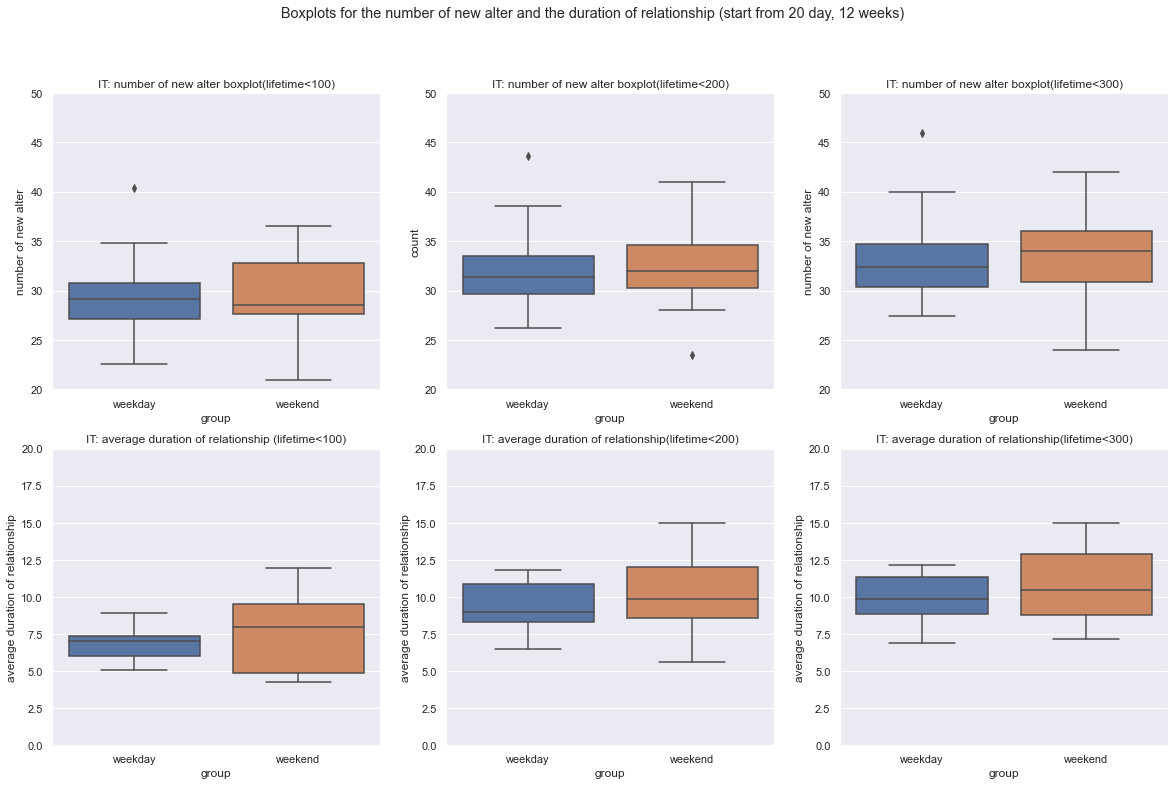

In [80]:
sns.set(rc={'figure.figsize':(20,12)})

fig, axes = plt.subplots(2, 3)
plt.suptitle('Boxplots for the number of new alter and the duration of relationship (start from 20 day, 12 weeks)')
sns.boxplot(x='group', y='count', data=count100, ax=axes[0,0]).set_title("IT: number of new alter boxplot(lifetime<100)")
sns.boxplot(x='group', y='count', data=count200, ax=axes[0,1]).set_title("IT: number of new alter boxplot(lifetime<200)")
sns.boxplot(x='group', y='count', data=count300, ax=axes[0,2]).set_title("IT: number of new alter boxplot(lifetime<300)")

sns.boxplot(x='group', y='mean', data=lifetime100, ax=axes[1,0]).set_title("IT: average duration of relationship (lifetime<100)")
sns.boxplot(x='group', y='mean', data=lifetime200, ax=axes[1,1]).set_title("IT: average duration of relationship(lifetime<200)")
sns.boxplot(x='group', y='mean', data=lifetime300, ax=axes[1,2]).set_title("IT: average duration of relationship(lifetime<300)")

axes[0,0].set(ylim=(20, 50))
axes[0,0].set(ylabel='number of new alter')
axes[0,1].set(ylim=(20, 50))
axes[0,2].set(ylabel='number of new alter')
axes[0,2].set(ylim=(20, 50))
axes[0,2].set(ylabel='number of new alter')
axes[1,0].set(ylim=(0, 20))
axes[1,0].set(ylabel='average duration of relationship')
axes[1,1].set(ylim=(0, 20))
axes[1,1].set(ylabel='average duration of relationship')
axes[1,2].set(ylim=(0, 20))
axes[1,2].set(ylabel='average duration of relationship')
